###### Introduction

** Water Solubility (logS)**

- Regression predicts LogS from compounds Avalon fingerprint
- Data: 9982 compounds from AqSolDB

Ref:
https://github.com/Zerwer/Chemistry
https://www.amdlab.nl/database/AqSolDB/

###### 1. Reading the dataset

In [1]:
import pandas as pd
import numpy as np
import csv
from tqdm import tqdm
from rdkit.rdBase import BlockLogs

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from rdkit.Avalon.pyAvalonTools import GetAvalonFP

In [3]:
def get_smiles_solibity(filename):
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        next(reader)
        
        smiles = []
        sol = []
        for row in reader:
            smiles.append(row[3])
            sol.append(float(row[4]))
        return smiles, sol

In [4]:
def get_ap_fps(smiles):

    fps = []
    for s in tqdm(smiles):
        mol = Chem.MolFromSmiles(s)
        np_fp = np.zeros((1,))
        fp = GetAvalonFP(mol)
        DataStructs.ConvertToNumpyArray(fp,np_fp)
        fps.append(fp)
    return fps

In [5]:
data = get_smiles_solibity('/home/sphalo/data_science/data/AqSolDB_v1.0_min.csv')

In [6]:
block = BlockLogs()
fingerprints = get_ap_fps(data[0])
del block

100%|█████████████████████████████████████████████████████████| 9982/9982 [00:06<00:00, 1459.14it/s]


###### 2. Features and Outputs

In [7]:
X = np.array(fingerprints)
y = np.array(data[1])

###### 3. Model Evaluation Using KFold Cross Validation

In [8]:
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

In [9]:
# features and outputs
X = np.array(fingerprints)
y = np.array(data[1])

# kf object
kf = KFold(n_splits=10, shuffle=True, random_state=1)

# create model
model = SVR()

# metrices
mse_train = []
mse_test = []

r2_train = []
r2_test = []

# k fold loop
for train_index, test_index in kf.split(X,y):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    
    # model
    model.fit(X_train, y_train)
    
    # metrics
    mse_train.append(mean_squared_error(y_train, model.predict(X_train)))
    mse_test.append(mean_squared_error(y_test, model.predict(X_test)))
    
    r2_train.append(r2_score(y_train, model.predict(X_train)))
    r2_test.append(r2_score(y_test, model.predict(X_test)))

In [10]:
# evaluate the model
print(f'Train set R^2: {np.mean(r2_train):.3f}')
print(f'Train set MSE score: {np.mean(mse_train):.3f}')
print()
print(f'Test set R^2: {np.mean(r2_test):.3f}')
print(f'Test set MSE score: {np.mean(mse_test):.3f}')

Train set R^2: 0.775
Train set MSE score: 1.264

Test set R^2: 0.695
Test set MSE score: 1.709


In [11]:
# scatter plots
import matplotlib.pyplot as plt
plt.rcdefaults()

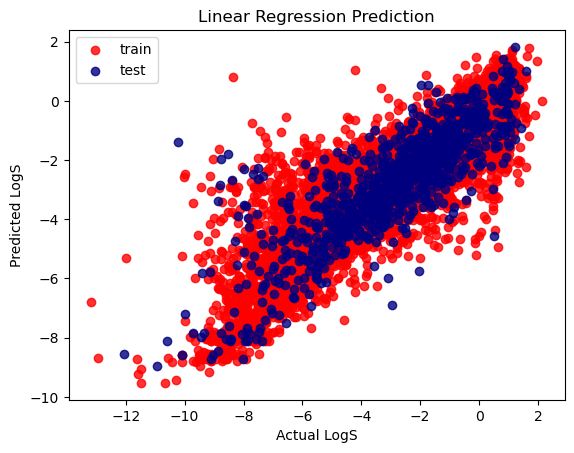

In [12]:
plt.title("Linear Regression Prediction")
plt.xlabel("Actual LogS")
plt.ylabel("Predicted LogS")
plt.rcParams["figure.figsize"] = [6,6]
plt.scatter(y_train, model.predict(X_train), 
            color="red", alpha=0.8, label="train")
plt.scatter(y_test, model.predict(X_test), 
            color="navy", alpha=0.8, label="test")
plt.legend(loc = 'best')
plt.show()

###### 4. Feature Scaling

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
# features and outputs
X = np.array(fingerprints)
y = np.array(data[1])

# kf object
kf = KFold(n_splits=10, shuffle=True, random_state=1)

# create scaler
scaler = StandardScaler()

# create model
model = SVR()

# metrices
mse_train = []
mse_test = []

r2_train = []
r2_test = []

# k fold loop
for train_index, test_index in kf.split(X,y):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
        
    # scaler
    scaler.fit(X_train)

    # transform and standaize features
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # model
    model.fit(X_train, y_train)
    
    # metrics
    mse_train.append(mean_squared_error(y_train, model.predict(X_train)))
    mse_test.append(mean_squared_error(y_test, model.predict(X_test)))
    
    r2_train.append(r2_score(y_train, model.predict(X_train)))
    r2_test.append(r2_score(y_test, model.predict(X_test)))

In [15]:
# evaluate the model
print(f'Train set R^2: {np.mean(r2_train):.3f}')
print(f'Train set MSE score: {np.mean(mse_train):.3f}')
print()
print(f'Test set R^2: {np.mean(r2_test):.3f}')
print(f'Test set MSE score: {np.mean(mse_test):.3f}')

Train set R^2: 0.769
Train set MSE score: 1.294

Test set R^2: 0.680
Test set MSE score: 1.791


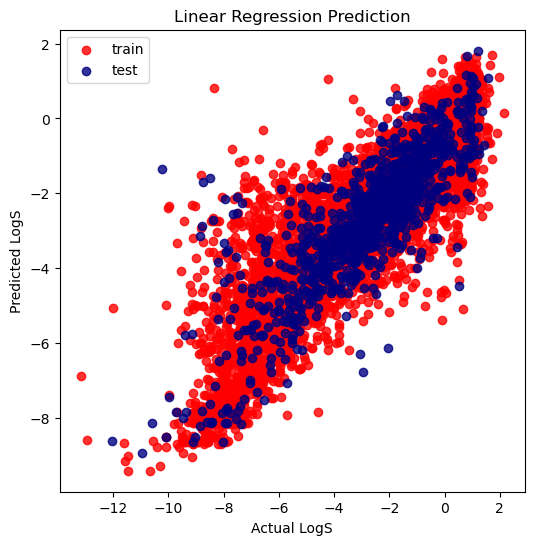

In [16]:
plt.title("Linear Regression Prediction")
plt.xlabel("Actual LogS")
plt.ylabel("Predicted LogS")
plt.rcParams["figure.figsize"] = [6,6]
plt.scatter(y_train, model.predict(X_train), 
            color="red", alpha=0.8, label="train")
plt.scatter(y_test, model.predict(X_test), 
            color="navy", alpha=0.8, label="test")
plt.legend(loc = 'best')
plt.show()

In [17]:
# no improvement after feature scaling

###### 5. Predictions

In [18]:
def get_fps(smiles):
    
    mol = Chem.MolFromSmiles(smiles)
    np_fp = np.zeros((1,))
    fp = GetAvalonFP(mol)
    DataStructs.ConvertToNumpyArray(fp,np_fp)
    fp = np.array(fp)
    fp = fp.reshape(1,-1) # convert to a 2D
    print('Predicted LogS is:')
    return fp

In [19]:
model.predict(get_fps('CCCCC(C)C(C)C'))

Predicted LogS is:


array([-2.93822702])

In [20]:
# using the fingerprint function created during loading dataset
model.predict(get_ap_fps(['CCCCC(C)C(C)C', 'CCCCC(C)C(C)C']))

100%|███████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1883.81it/s]


array([-2.93822702, -2.93822702])

###### 6. Saving the model

In [21]:
import joblib

In [22]:
svr_model = joblib.dump(model, 'svr_model')

In [23]:
class predictLogS(object):
    """
    Provide a user interface for predicting solubility(logS).
    Input -> smiles string, Output -> logS
    """
    def __init__(self, smiles):
        """Initialize attributes to generate fingerprints."""
        self.smiles = smiles
        
    def predict(self):
        """Generate fingerprints and predict logS using fingerprints."""
        # generate fingerprints
        mol = [Chem.MolFromSmiles(x) for x in tqdm(self.smiles)]
        np_fp = np.zeros((1,))
        fp = GetAvalonFP(mol[0])
        DataStructs.ConvertToNumpyArray(fp,np_fp)
        fp = np.array(fp)
        fp = fp.reshape(1,-1) # convert to 2D
        
        # load model via joblib
        self.svr = joblib.load("svr_model")
        self.pred_logS = self.svr.predict(fp)
        print(f"Predicted LogS is: {float(self.pred_logS):.3f}")

In [24]:
logs = predictLogS(['CCCCC(C)C(C)C'])
logs.predict()

100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3418.34it/s]

Predicted LogS is: -2.938
